In [3]:
# REQUIRED IMPORTS FROM STANDARD PACKAGES

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import random
import scipy
import pandas as pd
import sklearn as sk
from os.path import join as pjoin
from glob import glob
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, cross_val_predict, validation_curve, GroupShuffleSplit
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.externals.joblib import parallel_backend
from sklearn.feature_selection import SelectPercentile, f_classif, chi2, SelectKBest
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, minmax_scale, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer
# IMPORTS FROM THE UTIL LIBRARY PROVIDED BY US

import util.vis as V
import util.helpers as H

# Normally, all libraries are loaded only once, 
# even if you execute the import code multiple times
# This code is helpful if you make your own helper libraries 
%load_ext autoreload
%autoreload 1
# list your libraries below with aimport: should ensure 
#they are reloaded each time without having to restart your kernel
# in this case, our libraries are used as an example

%aimport util.helpers, util.vis
%aimport features_extraction
%aimport augmentation
%aimport Analysis
%aimport validation
%aimport preprocessing
%aimport upsampling
%aimport Learning_curve

# seed random generator such that this notebook always returns the same values 
# (this is by no means necessary, but it is useful for reproducability of results)
rng = np.random.RandomState(42)
print("Environment Ready")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Environment Ready


In [5]:
# PATHS

DATA_DIR = '../data'
POSE_DIR = '../data/pose'
print("Paths Ready")

Paths Ready


## Loading data
Loading all the training and test data

In [7]:
def keep_sample(sample):
    counter = 0
    no_hands_present = False
    for frame in sample:
        if (frame[4][0] == 0 or frame[7][0] == 0):
            counter += 1
        if (frame[4][0] == 0 and frame[7][0] == 0):
            no_hands_present = True
    if counter/len(sample) > 0.5 or no_hands_present:
        return False
    else:
        return True
##Loading all the training data
dataset_file=pjoin(DATA_DIR,'labels.csv')

train_samples=[]
train_labels=[]
train_persons = []
train_personlabels = []

with open(dataset_file) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    sample_index = 0
    preprocessing_outliers = [229, 297, 1316, 1780, 1817, 49, 495, 541, 746, 878, 2910]
    outliers_jens_fixing_gap1 = [85 , 398 , 717 , 766 , 923 , 979 ,1111 ,1280 ,1671 ,1778 ,1960 ,1993 ,2038 ,2089, 2097, 2135 ,2140, 2145, 2417 ,2463 ,2554 ,2579, 2594, 2794, 2832 ,2975, 3138, 3211, 3215, 3325 ,3341 ,3396 ,3399 ,3482 ,3566, 3649, 3702]
    outliers_jens_fixing_gap2 = [264,322,578,592,663,717,766,770,885,888,894,901,906,917,923,933,949,954,964,979,986,1117,1151,1152,1159,1161,1171,1199,1227,1257,1297,1573,1600,1607,1665,1671,1684,1701,1767,1778,1831,1859,1883,1930,1931,1932,1943,1960,1972,1993,1999,2037,2050,2056,2060,2089,2091,2097,2106,2119,2135,2140,2167,2191,2209,2231,2232,2235,2260,2268,2289,2334,2336,2538,2551,2554,2579,2602,2614,2637,2683,2688,2694,2699,2726,2741,2787,2803,2810,2841,2844,2845,2848,2887,2888,2893,2902,2943,2947,2954,2967,2975,2984,2990,3037,3064,3073,3078,3087,3103,3118,3119,3136,3138,3149,3170,3283,3293,3298,3305,3332,3342,3435,3475,3482,3561,3589,3590,3621,3629,3641,3649,3658,3672,3693,3697,3699,3702,3709,3710]
    outliers_robbe_fixing_gap = [2538, 1753, 1327, 2954, 2956, 2958, 4, 1111, 1117, 1118, 2167, 1992, 1993, 1573, 1575, 1576, 977, 245, 1846, 1909, 2435, 2545, 2590, 2815, 3515, 396, 421, 434, 494, 676, 718, 795, 815, 821, 882, 977, 991, 1016, 1035, 1111, 1295, 1308, 1524, 1564, 1586, 1633, 1634, 1804]
    #add [2538, 1753, 1327, 2954, 2956, 2958, 4, 1111, 1117, 1118]
    for row in reader: 
        name, _gloss, label, _person = row
        sample = np.load(pjoin(POSE_DIR, 'train', name+'.npy'))
        #if (sample_index not in preprocessing_outliers) and (sample_index not in outliers_jens_fixing_gap1) and (sample_index not in outliers_jens_fixing_gap2) and (sample_index not in outliers_robbe_fixing_gap):            
        if keep_sample(sample):
            train_samples.append(sample)
            train_labels.append(int(label))
            train_persons.append(_person)
            train_personlabels.append((label, _person))
        sample_index += 1

train_samples=np.array(train_samples)
train_labels=np.array(train_labels)

##Loading all the test data
all_test_files = sorted(glob(pjoin(POSE_DIR, 'test', '*.npy')))  

test_samples = []
for numpy_file in all_test_files:
    sample = np.load(numpy_file)
    test_samples.append(sample)
    
test_samples = np.array(test_samples)
print("Data Ready")

Data Ready


In [40]:
#Code to determine the outliers
temp = []
for i in range(len(train_samples)):
    teller = 0
    for frame in train_samples[i]:
        if (frame[4][0] == 0 or frame[7][0] == 0) and not(frame[4][0] == 0 and frame[7][0] == 0):
            teller += 1
    if teller/len(train_samples[i]) > 0.5:
        temp.append(i)
temp=np.unique(temp)
print((temp))
print(len(train_samples))

[]
3560


## Balancing the data with downsampling


In [27]:
"""
train_samples, train_labels, train_label_list, train_persons = upsampling.downsample(train_samples, train_labels, train_persons)
print(len(train_samples), len(train_labels), train_label_list)
print(train_samples[0].shape)
"""

2052 2052 [114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114]
(10, 137, 3)


## Balancing the data with upsampling

In [18]:
"""
upsampled_samples, upsampled_labels, upsampled_label_list, upsampled_persons = upsampling.upsample(train_samples, train_labels, train_persons, train_personlabels)
print(len(upsampled_samples), len(upsampled_labels), upsampled_label_list, len(upsampled_persons))
train_samples = np.array(upsampled_samples)
train_labels = np.array(upsampled_labels)
train_persons = np.array(upsampled_persons)
"""

5458 5458 [388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388] 6984


## Data augmentation

In [10]:
#train_samples = augmentation.augment_data(train_samples)
#train_labels = np.concatenate(( train_labels,train_labels, train_labels))
#train_persons = np.concatenate(( train_persons,train_persons, train_persons))
#train_personlabels = np.concatenate(( train_personlabels,train_personlabels, train_personlabels))

## Data preprocessing

In [25]:
#train_samples = preprocessing.rotate(train_samples)
#train_samples = preprocessing.scale(train_samples)
train_samples = preprocessing.centering(train_samples)

#test_samples = preprocessing.rotate(test_samples)
#test_samples = preprocessing.scale(test_samples) 
test_samples = preprocessing.centering(test_samples)

--- Centering finished ---
--- Centering finished ---


## Getting rid of the gap

In [8]:
seed = 24
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)
#for fold_ind, (dev_ind, val_ind) in enumerate(sgkf):
    #print(fold_ind, dev_ind)
    #print("============================")

In [ ]:
"""
for frame in train_samples[2737]:
    V.visualize(frame)
"""

## Extracting features
Here we use the features from the example notebook

In [42]:
def extract_features(samples_list):
    # Calculate the average over time
    l = [np.mean(sample, axis=0) for sample in samples_list] 
    # Create a numpy array
    X = np.stack(l, axis=0)  
    # Reshape to (n_samples, n_features)
    X = X.reshape((len(samples_list), -1))                    
    return X

#X_train = extract_features(train_samples)
y_train = np.array(train_labels)
#X_test = extract_features(test_samples)
X_train = features_extraction.extract_features(train_samples).values
X_test = features_extraction.extract_features(test_samples).values
num_features = X_train.shape[1]
print("Number of features : ", num_features)

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jensjanssens/Documents/1st_master/MachineLearning/Competition/ML_competition/features_extraction.py:1228: 

Number of features :  657


## Loss functions
Custom scoring functions

In [13]:
##Custom scoring functions

def top3_acc_score(y_true, proba):
    return H.mapk(proba,y_true)

def map3_score(y_true, proba):
    return H.top3_accuracy(proba, y_true)
    

acc = make_scorer(accuracy_score)
top3_acc = make_scorer(top3_acc_score, needs_proba=True) 
map3 = make_scorer(map3_score, needs_proba=True)
scoring_functions = {"acc": acc, "top3_acc": top3_acc, "map3": map3}

## Validation strategy

In [14]:
##Train validate data splitter for Cross Validation
seed = np.random.randint(1,999)
print("seed: ", seed)
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)

seed:  134


## Pipeline & model training

In [45]:
# the function below generates our rescaled pipeline model
# with optimized hyperparameters (e.g.: regularisation parameter)
def tune_C_logreg(x_data,r_data,verbose=0):
    pipe = Pipeline([
        ('scale', StandardScaler()),
        #('pca', PCA(n_components=325)),
        ('selectkbest', SelectKBest(f_classif)), 
        ('logreg', LogisticRegression(multi_class='multinomial', class_weight='balanced'))
    ])

    # Set the parameters by cross-validation
    tuned_parameters = {'logreg__C': np.logspace(-3, -1, 2) ,'logreg__solver': ['sag'], 'selectkbest__k': np.arange(265, 275, 5)}

    print("------ Start tuning hyperparameters ------")
    CV = GridSearchCV(pipe, tuned_parameters, n_jobs=-1, scoring=map3, pre_dispatch='n_jobs', cv=sgkf, verbose=2, return_train_score=True)
    with parallel_backend('threading'):
        CV.fit(x_data, r_data)
    print("------ Tuning hyperparameters finished ------")
    
    bestC = CV.best_params_['logreg__C']
    bestSolver = CV.best_params_['logreg__solver']
    bestK = CV.best_params_['selectkbest__k']
    print("Optimal regularisation value: ", bestC)
    print("Optimal solver: ", bestSolver)
    print("Optimal k value: ", bestK)
    
    optimal_pipe = Pipeline([
        ('scale', StandardScaler()),
        #('pca', PCA(n_components=325)),
        ('selectkbest', SelectKBest(f_classif, k=bestK)),
        ('logreg', LogisticRegression(C=bestC, multi_class='multinomial', solver=bestSolver, class_weight='balanced'))
    ])
    
    if verbose>0:
        print("Grid validation scores on training data set:")
        cv_means = CV.cv_results_['mean_test_score']
        print(cv_means)
        cv_stds = CV.cv_results_['std_test_score']
        for mean, std, params in zip(cv_means, cv_stds, CV.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    return optimal_pipe, CV.cv_results_

In [46]:
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)

optimal_pipe, res = tune_C_logreg(X_train, y_train, 1)

##Train validate data splitter for Cross Validation
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)

with parallel_backend('threading'):
    scores = cross_val_score(optimal_pipe, X_train, y_train, scoring=map3, cv=sgkf, n_jobs=-1, pre_dispatch='n_jobs')
print(scores)
print("Average (cross validated) map@3 score: ",scores.mean(),", stdev: ",scores.std())

optimal_pipe.fit(X_train, y_train)

------ Start tuning hyperparameters ------
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=265 .........
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=265 .........
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=265 .........
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=265 .........
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=265 .........
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=267 .........
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=267 .........
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=267 .........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=265, total=   3.9s
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=267 .........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=265, total=   4.8s
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=267 .........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=265, total=   5.2s
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=269 .........
[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=267, total=   5.3s
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=269 .........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=267, total=   5.6s
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=269 .........
[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=265, total=   5.7s
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=269 .........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=265, total=   6.2s
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=269 .........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=267, total=   6.6s
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=271 .........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=267, total=   4.3s
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=271 .........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=267, total=   3.9s
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=271 .........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=269, total=   3.5s
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=271 .........
[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=269, total=   4.2s


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=271 .........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=269, total=   5.0s
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=273 .........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=269, total=   5.1s
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=273 .........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=269, total=   6.0s
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=273 .........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=271, total=   5.0s
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=273 .........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=271, total=   3.7s
[CV] logreg__C=0.001, logreg__solver=sag, selectkbest__k=273 .........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=271, total=   5.1s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=265 
[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=271, total=   4.4s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=265 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=271, total=   6.4s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=265 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=273, total=   4.9s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=265 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=273, total=   4.0s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=265 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=273, total=   5.3s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=267 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=273, total=   6.4s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=267 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.001, logreg__solver=sag, selectkbest__k=273, total=   4.1s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=267 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=265, total=   6.3s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=267 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=265, total=   7.5s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=267 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=265, total=   9.4s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=269 
[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=265, total=   9.4s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=269 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=265, total=   9.4s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=269 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=267, total=   9.6s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=269 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=267, total=   8.8s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=269 
[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=267, total=   9.8s


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.1s
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=271 
[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=267, total=   6.9s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=271 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=267, total=   8.2s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=271 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=269, total=   9.9s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=271 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=269, total=   9.5s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=271 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=269, total=  10.3s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=273 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=269, total=   7.3s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=273 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=269, total=   8.6s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=273 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=271, total=  11.1s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=273 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=271, total=  10.0s
[CV] logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=273 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=271, total=  12.1s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=265 ..........
[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=271, total=   8.3s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=265 ..........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=271, total=   9.3s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=265 ..........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=273, total=  11.4s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=265 ..........
[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=273, total=  10.5s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=265 ..........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165

[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=273, total=  12.3s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=267 ..........
[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=273, total=   8.5s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=267 ..........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.0031622776601683794, logreg__solver=sag, selectkbest__k=273, total=   8.1s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=267 ..........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=265, total=  10.1s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=267 ..........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=265, total=  10.6s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=267 ..........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=265, total=  10.4s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=269 ..........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=265, total=  10.1s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=269 ..........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=265, total=  10.2s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=269 ..........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=267, total=  10.7s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=269 ..........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=267, total=  10.7s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=269 ..........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=267, total=  10.7s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=271 ..........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=267, total=  10.5s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=271 ..........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=267, total=  10.8s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=271 ..........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=269, total=  10.8s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=271 ..........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=269, total=  10.7s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=271 ..........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=269, total=  10.6s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=273 ..........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=269, total=  10.5s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=273 ..........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=269, total=  10.5s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=273 ..........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=271, total=  10.4s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=273 ..........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=271, total=  10.5s
[CV] logreg__C=0.01, logreg__solver=sag, selectkbest__k=273 ..........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=271, total=  10.6s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=265 


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=271, total=  10.8s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=265 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=271, total=  11.1s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=265 
[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=273, total=  11.0s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=265 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=273, total=  11.1s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=265 
[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=273, total=  11.4s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=267 


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=273, total=  11.4s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=267 


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.01, logreg__solver=sag, selectkbest__k=273, total=  11.6s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=267 


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=265, total=  11.2s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=267 


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=265, total=  11.1s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=267 


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=265, total=  11.0s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=269 
[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=265, total=  11.0s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=269 


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=265, total=  11.5s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=269 
[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=267, total=  11.5s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=269 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=267, total=  11.2s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=269 


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=267, total=  11.3s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=271 


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=267, total=  11.3s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=271 


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=267, total=  11.6s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=271 


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=269, total=  11.2s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=271 
[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=269, total=  11.2s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=271 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=269, total=  10.8s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=273 
[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=269, total=  10.9s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=273 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=269, total=  11.2s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=273 


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=271, total=  11.5s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=273 
[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=271, total=  11.3s
[CV] logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=273 


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=271, total=  11.6s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=265 ...........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=271, total=  12.1s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=265 ...........
[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=271, total=  12.0s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=265 ...........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=273, total=  12.1s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=265 ...........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=273, total=  12.7s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=265 ...........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=273, total=  12.5s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=267 ...........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=273, total=  11.7s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=267 ...........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.03162277660168379, logreg__solver=sag, selectkbest__k=273, total=  11.8s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=267 ...........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=265, total=  11.4s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=267 ...........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=265, total=  10.9s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=267 ...........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=265, total=  11.2s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=269 ...........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=265, total=  11.4s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=269 ...........
[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=265, total=  11.1s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=269 ...........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=267, total=  11.3s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=269 ...........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=267, total=  11.6s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=269 ...........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=267, total=  12.0s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=271 ...........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=267, total=  11.8s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=271 ...........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=267, total=  11.9s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=271 ...........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=269, total=  12.0s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=271 ...........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=269, total=  11.5s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=271 ...........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=269, total=  11.7s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=273 ...........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=269, total=  11.9s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=273 ...........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=269, total=  11.6s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=273 ...........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=271, total=  11.4s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=273 ...........


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=271, total=  11.3s
[CV] logreg__C=0.1, logreg__solver=sag, selectkbest__k=273 ...........


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=271, total=  11.1s
[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=271, total=  11.0s
[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=271, total=  11.0s
[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=273, total=  10.9s
[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=273, total=   9.4s
[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=273, total=   7.9s
[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=273, total=   7.8s
[CV]  logreg__C=0.1, logreg__solver=sag, selectkbest__k=273, total=   7.5s


[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  2.5min finished
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


------ Tuning hyperparameters finished ------
Optimal regularisation value:  0.03162277660168379
Optimal solver:  sag
Optimal k value:  273
Grid validation scores on training data set:
[0.78426966 0.78455056 0.78342697 0.78426966 0.78511236 0.80561798
 0.80758427 0.80646067 0.80702247 0.80505618 0.81629213 0.81657303
 0.81657303 0.81769663 0.81769663 0.81825843 0.82050562 0.82106742
 0.82162921 0.8238764  0.81544944 0.81460674 0.81488764 0.81460674
 0.81348315]
0.784 (+/-0.020) for {'logreg__C': 0.001, 'logreg__solver': 'sag', 'selectkbest__k': 265}
0.785 (+/-0.022) for {'logreg__C': 0.001, 'logreg__solver': 'sag', 'selectkbest__k': 267}
0.783 (+/-0.025) for {'logreg__C': 0.001, 'logreg__solver': 'sag', 'selectkbest__k': 269}
0.784 (+/-0.026) for {'logreg__C': 0.001, 'logreg__solver': 'sag', 'selectkbest__k': 271}
0.785 (+/-0.027) for {'logreg__C': 0.001, 'logreg__solver': 'sag', 'selectkbest__k': 273}
0.806 (+/-0.016) for {'logreg__C': 0.0031622776601683794, 'logreg__solver': 'sag', '

/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[0.82076814 0.80747922 0.83469945 0.82409972 0.83113069]
Average (cross validated) map@3 score:  0.8236354455278942 , stdev:  0.009466271302400863


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectkbest', SelectKBest(k=273, score_func=<function f_classif at 0x1a0fa6bea0>)), ('logreg', LogisticRegression(C=0.03162277660168379, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='sag', tol=0.0001, verbose=0,
          warm_start=False))])

In [ ]:
index_best_fit = 8
train_score_CV = [res['split0_train_score'][index_best_fit], res['split1_train_score'][index_best_fit], res['split2_train_score'][index_best_fit], res['split3_train_score'][index_best_fit], res['split4_train_score'][index_best_fit]]
val_score_CV = [res['split0_test_score'][index_best_fit], res['split1_test_score'][index_best_fit], res['split2_test_score'][index_best_fit], res['split3_test_score'][index_best_fit], res['split4_test_score'][index_best_fit]]
print("Train",train_score_CV)
print("Val",val_score_CV)

## Generate kaggle submission file

In [47]:
test_probas = optimal_pipe.predict_proba(X_test)
H.create_submission(test_probas, 'logreg_fin.csv')

## Model analysis
Generate confusion matrix on validation data

/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [161 162 164 165] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


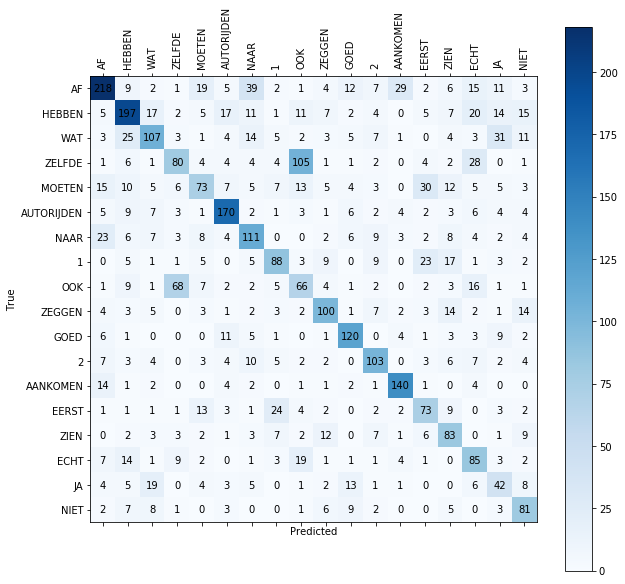

In [48]:
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)
with parallel_backend('threading'):
    y_pred = cross_val_predict(optimal_pipe, X_train, y_train, cv=sgkf, n_jobs=-1, pre_dispatch='n_jobs')
Analysis.plot_confusion_matrix(confusion_matrix(y_train, y_pred))

Calculate the precision, recall, F1 score, TP, FP and NP

In [ ]:
##ANALYSIS
train_probas = optimal_pipe.predict_proba(X_train)
prob_order = H.get_ordered_predictions(train_probas)
# Get the top prediction per sample.
top_prob = prob_order[:,:1]
top_prob_2= prob_order[:,1:2]
top_prob_3= prob_order[:,2:3]

target_names = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17']
print('k 1')
print(classification_report(y_train, top_prob, target_names=target_names))
print('k 2')
print(classification_report(y_train, top_prob_2, target_names=target_names))
print('k 3')
print(classification_report(y_train, top_prob_3, target_names=target_names))

# Learning Curve

In [ ]:
title = "Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
#cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
sgkf = validation.stratified_group_k_fold(train_samples, train_labels, train_persons, 5, seed)
estimator = optimal_pipe
Learning_curve.plot_learning_curve(estimator, title, X_train, y_train, map3,ylim=(0.1, 1.01), cv=sgkf, n_jobs=4)

plt.show()